In [1]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.interpolate as interpolate

from joblib import Parallel, delayed


In [2]:
# Load the relevant vectors
r_o   = 1.0e+3           # outer radius (maximum radius)
r_c   = 1.0e-1           # central radius (minimum radius)
P_c   = 1.0e+2           # central pressure (maximal pressure)
center_value = 10**(-7)  # center value
sigma        = 10**(-8)  # width of the full Gaussian
amplitude    = 1         # scale factor

filename = f'data/perturbed_tov_{round(np.log10(r_o)):+}{round(np.log10(r_c)):+}{round(np.log10(P_c)):+}{center_value:+}{amplitude:+}{sigma:+}.npy'
loaded_data = np.load(filename)
R, E_perturbed, S_perturbed, Sr_perturbed, v_perturbed = loaded_data

# Define the maximal integration bound
R_max = np.max(R)

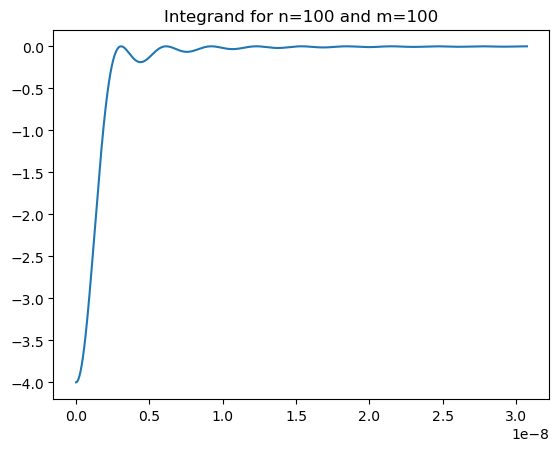

In [3]:
# Relevant functions
k = lambda x   : 2 / x**2
l = lambda n, x: np.sqrt(2) * np.sin(n * np.pi * x / R_max)
λ = lambda n   : - (n * np.pi / R_max)**2

# Integration
def integrand(x, n, m):
    # denumerator: negative due to the product of two complex values
    return l(n, x) * k(x) * np.conj(l(m, x)) / (- np.sqrt(-λ(n)) * np.sqrt(-λ(m)))              

# Visulation of the integrand
n, m = 100, 100
x_val = np.linspace(10**(-16), R_max/10, 100000)
plt.figure
plt.plot(x_val, integrand(x_val, n, m));
plt.title(f"Integrand for n={n} and m={m}");

In [4]:
# Computation of K tilde
n_max, m_max = 100, 100

def compute_integral(n, m):
    return integrate.quad(integrand, 0, R_max, args=(n + 1, m + 1))[0]

K_tilde =  (- np.sqrt(-λ(n)) * np.sqrt(-λ(m))) * np.array(Parallel(n_jobs=-1)(delayed(compute_integral)(n, m) for n in range(n_max) for m in range(m_max))).reshape(n_max, m_max)


In [5]:
# Computation of lambda dirac
lambda_dirac = np.diag([(- np.sqrt(-λ(n)) * np.sqrt(-λ(n))) for n in range(n_max)])

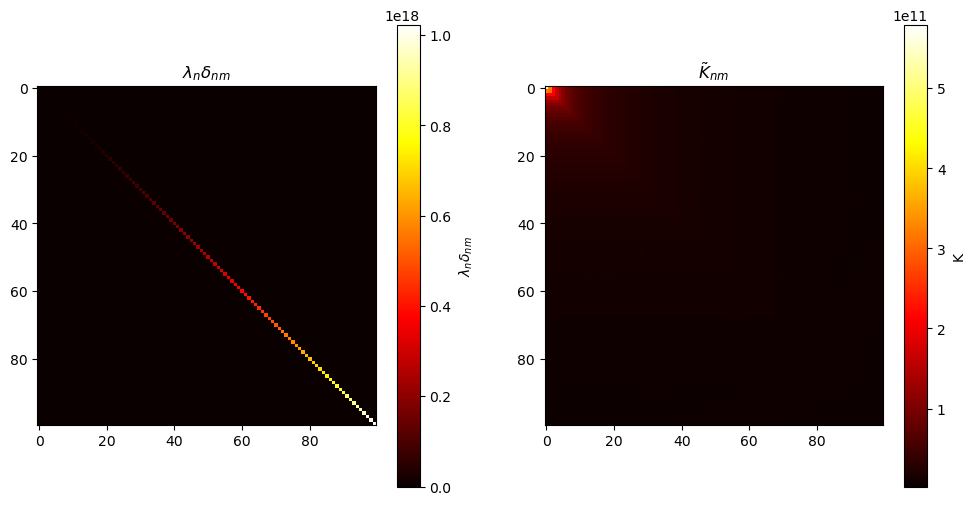

In [6]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First subplot: abs(lambda_dirac)
im1 = axes[0].imshow(np.abs(lambda_dirac), cmap="hot")
axes[0].set_title(r"$\lambda_n \delta_{nm}$")
fig.colorbar(im1, ax=axes[0], label=r"$\lambda_n \delta_{nm}$")

# Second subplot: abs(K)
im2 = axes[1].imshow(K_tilde, cmap="hot")
axes[1].set_title(r"$\tilde{K}_{nm}$")
fig.colorbar(im2, ax=axes[1], label="K")

In [58]:
# Reformulate the problem as Cx = d
C = lambda_dirac + K_tilde


In [75]:
# Interpolation of Sr_perturbed
Sr_perturbed_int = interpolate.interp1d(R, Sr_perturbed, kind='cubic', fill_value="extrapolate")

def integrand_b(x, n):
    return l(n, x) * Sr_perturbed_int(x)

d = np.zeros(C.shape[0]).squeeze()
for n in range(n_max):
    d[n] = integrate.quad(integrand_b, 0, R[-1], args=n+1)[0]
    

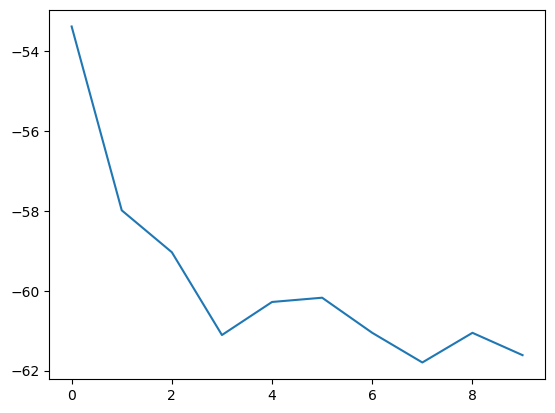

In [84]:
f = np.linalg.solve(C, d)
plt.plot(np.log(np.abs(f[0:10])))